# Exercise 2: Decision Trees

This notebook covers the implementation and analysis of Decision Tree algorithms for machine learning tasks.

## 1. Import Required Libraries

Import the necessary libraries for Decision Tree implementation and analysis.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
import graphviz
from sklearn.tree import export_graphviz
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Load, Split and Preprocess Data

First, load the dataset and split it into training, validation, and test sets (60/20/20).

In [20]:
# Load dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

# 60% train, 20% validation, 20% test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(X_train.shape, X_val.shape, X_test.shape)

(341, 30) (114, 30) (114, 30)


Then, preprocess the data by scaling the features using `StandardScaler`.

In [21]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

## 3. Basic Decision Tree Implementation

Implement a basic Decision Tree model with default parameters.

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold

dt = DecisionTreeClassifier(random_state=42)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_validate(
    dt, X_train_scaled, y_train,
    cv=cv,
    scoring=['accuracy', 'precision', 'recall', 'roc_auc'],
    return_train_score=True
)

for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_roc_auc']:
    print(f"{metric}: {scores[metric].mean():.3f} ± {scores[metric].std():.3f}")

test_accuracy: 0.909 ± 0.017
test_precision: 0.934 ± 0.010
test_recall: 0.921 ± 0.024
test_roc_auc: 0.905 ± 0.016


### Feature Importance

Now we will analyze the feature importance of the trained Decision Tree model.

In [23]:
dt.fit(X_train_scaled, y_train)
importances = dt.feature_importances_

# Sort features by importance
indices = importances.argsort()[::-1]
for idx in indices[:3]:
    print(f"{X_train.columns[idx]}: {importances[idx]:.4f}")

worst radius: 0.7110
worst concave points: 0.1580
texture error: 0.0390


Here, we see that the three most important features are:
- worst radius with a feature importance of 0.7110
- worst concave points with a feature importance of 0.1580
- texture error with a feature importance of 0.0390

These three features together account for approximately 90.8% of the total feature importance, indicating that they play a significant role in the model's decision-making process.

### Depth Analysis

Analyze the effect of tree depth on model performance by training Decision Trees with varying depths and evaluating their accuracy on the validation set.

In [24]:
depths = [2, 4, 6, 8, 10]
for d in depths:
    dt = DecisionTreeClassifier(max_depth=d, random_state=42)
    scores = cross_validate(dt, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    print(f"Depth {d}: {scores['test_score'].mean():.3f} ± {scores['test_score'].std():.3f}")

Depth 2: 0.947 ± 0.020
Depth 4: 0.927 ± 0.009
Depth 6: 0.921 ± 0.015
Depth 8: 0.909 ± 0.017
Depth 10: 0.909 ± 0.017


We observe that the accuracy on the accuracy on the validation set is highest at a depth of 2, and decreases as the depth increases beyond that point. This suggests that a depth of 2 provides the best balance between model complexity and generalization to unseen data.

Decision trees, if left unconstrained, will adapt itself to the training data, leading to overfitting. By limiting the depth of the tree, we can control its complexity and improve its ability to generalize to new data (Géron, p. 268, 2019).

### Evaluate the Model

We will now perform a grid search to find the optimal hyperparameters for the Decision Tree model.

In [25]:
param_grid = {
    'max_depth': [2, 3, 4, 5, 7, None],
    'min_samples_leaf': [1, 2, 4, 5, 10, 20]
}

grid_search = GridSearchCV(
    dt, param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

print("Best params:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

# Evaluate on validation set
val_acc = grid_search.score(X_val_scaled, y_val)
print("Validation accuracy:", val_acc)

Best params: {'max_depth': 2, 'min_samples_leaf': 5}
Best CV accuracy: 0.9530264279624895
Validation accuracy: 0.956140350877193


#### Max Depth Analysis

By analyzing the effect of the `max_depth` parameter on model performance, we can determine the optimal value for this parameter. The parameter controls the maximum depth of the tree, which can help prevent overfitting.

We observe that the accuracy on the accuracy on the validation set is highest at a depth of 2, and decreases as the depth increases beyond that point. This suggests that a depth of 2 provides the best balance between model complexity and generalization to unseen data.

#### Minimum Samples per Leaf Analysis

By analyzing the effect of the `min_samples_leaf` parameter on model performance, we can determine the optimal value for this parameter. The parameter controls the minimum number of samples required to be at a leaf node, which can help prevent overfitting.

Here we see that the Decision Tree model performs best when the `min_samples_leaf` parameter is set to five. This means that each leaf node in the tree must contain at least five samples, which helps to prevent overfitting and improve the model's generalization to unseen data. The accuracy of the model with this parameter setting is 0.953.

## 4. Test the Model

Finally, evaluate the best model on the test set to assess its performance on unseen data.

In [ ]:
# Combine train + val
X_combined = np.vstack((X_train_scaled, X_val_scaled))
y_combined = np.hstack((y_train, y_val))

best_dt = DecisionTreeClassifier(**grid_search.best_params_, random_state=42)
best_dt.fit(X_combined, y_combined)

y_pred = best_dt.predict(X_test_scaled)

print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test Precision:", precision_score(y_test, y_pred))
print("Test Recall:", recall_score(y_test, y_pred))
print("Test AUC:", roc_auc_score(y_test, best_dt.predict_proba(X_test_scaled)[:, 1]))

Test Accuracy: 0.9035087719298246
Test Precision: 0.9411764705882353
Test Recall: 0.9014084507042254
Test AUC: 0.9264657713724206


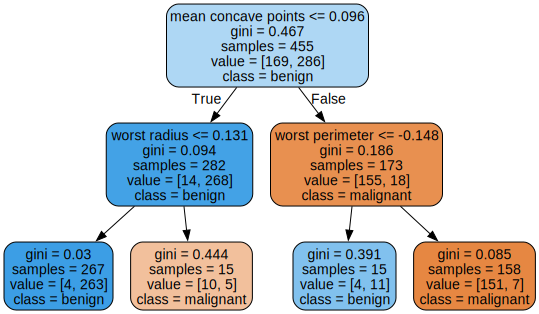

In [27]:
export_graphviz(
    best_dt,
    out_file="../reports/figures/tree.dot",
    feature_names=X.columns,
    class_names=data.target_names,
    rounded=True,
    filled=True
)
with open("../reports/figures/tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)